# Phishing Email Detection – Training and Testing Guide
This guide explains how to train and test a simple but powerful Phishing Email Detection Model using Kaggle datasets and Google Colab.
It walks through each step — from dataset download to real-time testing on your own email text.

## Step 1: Setup and Get Data
We start by:
1. Installing required Python packages.
2. Uploading the kaggle.json API token.
3. Downloading a phishing email dataset from Kaggle.
4. Loading and preparing the data.

### Install Required Packages

In [1]:
!pip -q install kaggle scikit-learn pandas joblib

#### Explanation
- `kaggle`: Access Kaggle datasets programmatically.
- `scikit-learn`: Machine learning toolkit for training the model.
- `pandas`: Data handling and cleaning.
- `joblib`: For model saving/loading (optional later).

--------
### Upload your kaggle.json API Token
This authenticates your access to Kaggle datasets.

In [2]:
from google.colab import files, os
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
uploaded = files.upload()

with open(os.path.expanduser("~/.kaggle/kaggle.json"), "wb") as f:
    f.write(uploaded['kaggle.json'])
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

Saving kaggle.json to kaggle.json


#### Explanation

- You’ll be prompted to upload your Kaggle API key file (kaggle.json).
- This file is downloaded from your Kaggle account under:

    **Profile → Account → Create New API Token.**

- The code creates the ~/.kaggle directory and sets correct file permissions for secure access.

## Download the Dataset

In [3]:
!kaggle datasets download -d naserabdullahalam/phishing-email-dataset -p /content -q
!unzip -qq /content/*.zip -d /content/data

Dataset URL: https://www.kaggle.com/datasets/naserabdullahalam/phishing-email-dataset
License(s): CC-BY-SA-4.0


#### Explanation
- Downloads a public Phishing Email dataset from Kaggle.
- Extracts it into /content/data for use in Colab.

## Load and Inspect the Dataset

In [4]:
import pandas as pd, glob

# Find first CSV file and load it
csv = glob.glob("/content/data/**/*.csv", recursive=True)[0]
df = pd.read_csv(csv, encoding='latin-1').dropna()
df.columns = [c.lower() for c in df.columns]

# Identify likely text and label columns
text_col = [c for c in df.columns if 'text' in c or 'message' in c or 'body' in c or 'email' in c][0]
label_col = [c for c in df.columns if 'label' in c or 'class' in c or 'spam' in c or 'phish' in c][0]

df = df[[text_col, label_col]].rename(columns={text_col:'text', label_col:'label'})
print("✅ Loaded", len(df), "emails")
df.head(3)

✅ Loaded 29569 emails


,text,label
0,( see attached file : hplno 525 . xls )\r\n- h...,0
1,- - - - - - - - - - - - - - - - - - - - - - fo...,0
2,"estimated actuals\r\nmarch 30 , 2001\r\nno flo...",0


#### Explanation:
- Automatically finds and reads the first .csv file inside the dataset folder.
- Cleans missing values (dropna()).
- Detects which columns contain email text and labels based on column names.
- Renames them to standardized columns:

    `text` → email content

    `label` → phishing/spam indicator

- Displays the first few rows for quick inspection.
---
## Step 2: Train Model

Now we train a lightweight, explainable model using text-based features.
---
Clean & Normalize Labels

In [5]:
# --- Robust label mapping ---
lab = df['label'].astype(str).str.lower().str.strip()

# Common tokens for spam and ham classes
SPAM_TOKENS = {'spam','phish','phishing','malicious','malware','attack','fraud','scam','bad','abusive','1','true','yes'}
HAM_TOKENS  = {'ham','legit','legitimate','benign','normal','not_spam','0','false','no','safe'}

def map_label(s):
    # exact match first
    if s in SPAM_TOKENS: return 1
    if s in HAM_TOKENS:  return 0
    # substring fallback
    if any(t in s for t in ['spam','phish','malic','attack','fraud','scam']): return 1
    if any(t in s for t in ['ham','legit','normal','safe']): return 0
    # numeric fallback
    if s.isdigit(): return int(s) if s in {'0','1'} else 0
    return 0  # default to ham if unknown

y = lab.apply(map_label).astype(int)
X = df['text'].astype(str)

#### Explanation

- Converts all labels to lowercase text.
- Maps common variants of phishing/spam labels (`spam`, `phish`, `fraud`, etc.) to 1.
- Maps safe/ham/legit labels to 0.
- The `map_label` function ensures the dataset works even if label names differ across sources.

### Clean Email Text

In [6]:
import re

def clean_email(t):
    t = t.replace('\r','\n')
    cleaned_lines = []
    for ln in t.splitlines():
        if not re.match(r'^(from:|to:|subject:|cc:|bcc:|date:|reply-to:)', ln.strip().lower()):
            cleaned_lines.append(ln)
    t = '\n'.join(cleaned_lines)
    t = re.sub(r'\s+', ' ', t).strip().lower()
    return t

X_clean = X.apply(clean_email)

#### Explanation
- Removes common email header lines (e.g., From, Subject, To).
- Normalizes whitespace and converts text to lowercase.
- Keeps URLs and numbers, which are often critical indicators of phishing.

---

## Feature Extraction (TF-IDF)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

tfidf_word = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, max_features=60000)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=2, max_features=60000)

Xw = tfidf_word.fit_transform(X_clean)
Xc = tfidf_char.fit_transform(X_clean)
Xv = hstack([Xw, Xc])

#### Explanation
- Uses TF-IDF (Term Frequency–Inverse Document Frequency) to turn text into numerical vectors.

- Two types of features are combined:

- Word-level features: Capture words and short phrases (n-grams).

- Character-level features: Capture URL and obfuscated word patterns often used in phishing.

- The two matrices are combined using `hstack()` for a rich representation.

----

## Train the Model

In [8]:
from sklearn.svm import LinearSVC
model = LinearSVC(class_weight='balanced', max_iter=3000)
model.fit(Xv, y)

print("Trained on", Xv.shape[0], "emails with", Xv.shape[1], "features")

Trained on 29569 emails with 120000 features


### Step: Training Accuracy & Performance Graph
This step computes the **training accuracy** of the fitted model and draws a graph. If a Keras `history` object is available from `model.fit(...)`, the chart will show accuracy per epoch; otherwise, it will plot a simple comparison of available metrics (e.g., train/test accuracy).

Training accuracy: 0.9999


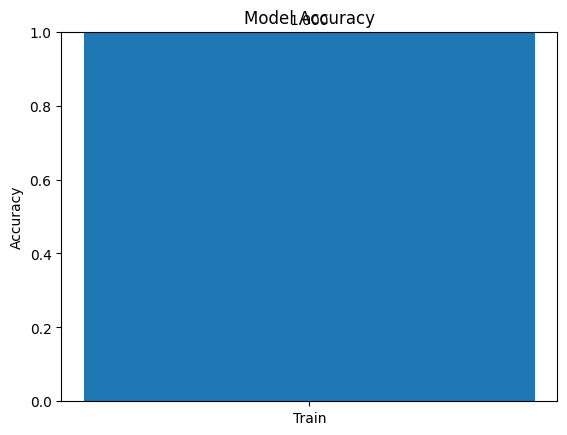

In [9]:
# === Training Accuracy & Graph ===
# This cell assumes the model and training data already exist from the previous step.
# Detected variables (best guess from the .fit(...) call):
MODEL_VAR = "model"
X_TRAIN_VAR = "Xv"
Y_TRAIN_VAR = "y"

# Resolve objects from globals
model = globals().get(MODEL_VAR)
X_train = globals().get(X_TRAIN_VAR)
y_train = globals().get(Y_TRAIN_VAR)

if model is None or X_train is None or y_train is None:
    raise RuntimeError(f"Expected variables not found. Got: "
                       f"model={type(model)}, X_train={type(X_train)}, y_train={type(y_train)}. "
                       f"Please make sure to run the training cell first.")

# Try to detect test split if present
X_test = globals().get("X_test")
y_test = globals().get("y_test")

# Compute training accuracy robustly (works for sklearn & Keras)
import numpy as np
from math import isnan
try:
    from sklearn.metrics import accuracy_score
except Exception as _e:
    accuracy_score = None

def to_label(pred):
    """Convert predictions to class labels if needed."""
    if isinstance(pred, np.ndarray):
        # Keras style: (n,1) or (n,) floats -> threshold at 0.5
        if pred.ndim == 2 and pred.shape[1] > 1:
            return pred.argmax(axis=1)
        if pred.ndim == 2 and pred.shape[1] == 1:
            return (pred.ravel() >= 0.5).astype(int)
        if pred.ndim == 1 and pred.dtype.kind in ("f","c"):
            return (pred >= 0.5).astype(int)
    return pred  # sklearn usually returns labels already

# Training predictions
train_pred_raw = model.predict(X_train)
y_train_pred = to_label(train_pred_raw)

if accuracy_score is None:
    raise RuntimeError("scikit-learn is required for accuracy_score. Please install scikit-learn.")

train_acc = accuracy_score(y_train, y_train_pred)
print(f"Training accuracy: {train_acc:.4f}")

# Optional: compute test accuracy if test split exists and the model can predict
test_acc = None
if X_test is not None and y_test is not None:
    try:
        test_pred_raw = model.predict(X_test)
        y_test_pred = to_label(test_pred_raw)
        test_acc = accuracy_score(y_test, y_test_pred)
        print(f"Test accuracy: {test_acc:.4f}")
    except Exception as e:
        print("Could not compute test accuracy:", e)

# Plotting
import matplotlib.pyplot as plt

# Case 1: Keras History object
history = globals().get("history")
plotted = False
if history is not None:
    # Compatible with tf.keras.callbacks.History or dict-like
    hist_dict = getattr(history, "history", None)
    if isinstance(hist_dict, dict):
        acc = hist_dict.get("accuracy") or hist_dict.get("acc")
        val_acc = hist_dict.get("val_accuracy") or hist_dict.get("val_acc")
        if acc is not None:
            plt.figure()
            plt.plot(acc, label="Train Accuracy")
            if val_acc is not None:
                plt.plot(val_acc, label="Validation Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Accuracy over Epochs")
            plt.legend()
            plt.grid(True, linestyle="--", alpha=0.4)
            plt.show()
            plotted = True

# Case 2: Fallback bar chart (train/test accuracy)
if not plotted:
    labels = ["Train"]
    values = [train_acc]
    if test_acc is not None:
        labels.append("Test")
        values.append(test_acc)

    plt.figure()
    plt.bar(labels, values)
    plt.ylim(0, 1)
    plt.ylabel("Accuracy")
    plt.title("Model Accuracy")
    for i, v in enumerate(values):
        plt.text(i, v + 0.02, f"{v:.3f}", ha="center")
    plt.show()


#### Explanation

- LinearSVC (Support Vector Machine) is efficient and robust for text classification.

- The `class_weight='balanced'` handles imbalance between spam and ham samples.

- Trains on the TF-IDF features to learn distinguishing patterns.

---
## Step 3: Test the Model
You can now input any text or email content to test the model’s prediction.
---

### Define the Test Function

In [10]:
from scipy.sparse import hstack

def check_email(email_text: str):
    v_w = tfidf_word.transform([clean_email(email_text)])
    v_c = tfidf_char.transform([clean_email(email_text)])
    v   = hstack([v_w, v_c])
    pred = model.predict(v)[0]
    return "PHISHING/SPAM" if pred == 1 else "Safe email"

#### Explanation

- Cleans your input email text.

- Converts it into both word and character TF-IDF feature vectors.

- Feeds it to the trained SVM model to predict phishing (1) or safe (0).

### Try Example Emails

In [11]:
print(check_email("Your account has been locked. Verify now at http://fakebank.com"))
print(check_email("Hi John, attached are the meeting minutes for today."))
print(check_email("Hey did you check this picture before, its great landscape http://someoddpic.sm"))

PHISHING/SPAM
Safe email
PHISHING/SPAM


#### Expected Output

```
PHISHING/SPAM
Safe email
PHISHING/SPAM
```

## Summary
| Step                      | Description                                |
| ------------------------- | ------------------------------------------ |
| **1. Setup**              | Install dependencies & authenticate Kaggle |
| **2. Download Data**      | Get a real phishing dataset                |
| **3. Preprocess**         | Clean text and normalize labels            |
| **4. Feature Extraction** | TF-IDF on words + characters               |
| **5. Train Model**        | Linear SVM classifier                      |
| **6. Test Model**         | Predict phishing vs safe emails            |
